# **Practical session n°7** : Learning-to-Rank and Re-identification

**Part I:**

Several problems fall under the label "[learning-to-rank](https://link.springer.com/content/pdf/10.1007/978-3-642-15880-3_20.pdf)." One example is sorting a given list of labels (e.g. URL of websites) by relevance to an input query. This problem is referred to as *label ranking*.\
 In another scenario, input objects (e.g. images) should be sorted wrt a given criterion (e.g. 'foggy' or 'snowy'). Terms like *object ranking* and *learning to order things* are often used to describe this situation. In both cases, the learning is based on sorted samples, such as pairs of ordered images.

In this practical session, we illustrate the latter scenario using very simple synthetic images. All images consist of a mixture of a disc and a variable number of rectangles of different shapes. The goal is to sort the images based on the pixel intensity on the disc. To achieve this, we work in a standard context where we have pairs of ordered images. Using these pairs, we will train a neural network to construct a real-valued "ranking function" (*ranker*) whose outputs enable the sorting of images.

**Exercise #1:** Problem Construction

The following cells enable you to:
- generate a dataset on your drive (train+val and test),
- define a dataset that provides pairs of images and a comparison based on the criterion of disc intensity ("0" if the disc is more intense in the first image, "1" otherwise),
- visualize an initial batch.

In [1]:
import os
from os.path import join
ls = lambda rep: sorted(os.listdir(rep))

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torch.utils.data import Dataset, DataLoader, sampler

import matplotlib.pyplot as plt
import copy
from random import randint, choice



In [8]:
# imports from a git repo
! git clone https://github.com/relmonta/ml-student.git

from archis import *

Cloning into 'ml-student'...
remote: Enumerating objects: 355, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 355 (delta 108), reused 90 (delta 82), pack-reused 210
Receiving objects: 100% (355/355), 46.92 MiB | 32.09 MiB/s, done.
Resolving deltas: 100% (148/148), done.
/bin/bash: -c: line 1: syntax error near unexpected token `'ml-student/TP7''
/bin/bash: -c: line 1: ` os.chdir('ml-student/TP7')'


ModuleNotFoundError: ignored

In [18]:
os.chdir('ml-student/TP7')

In [19]:
! ls

TP7_partI.ipynb  utile_tp7_partI.py


In [20]:
from utile_tp7_partI import *
#from train_and_test import *

root = r"/content"

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
dir_trainval = join(root, r"train")
generate_dataset(dir_trainval, size_dataset=10000)

dir_test = join(root, r"test")
generate_dataset(dir_test, size_dataset=2000)

In [23]:
# Retrieving target values

# Image paths:
dir_images_trainval = os.path.join(dir_trainval, 'images')
dir_images_test = os.path.join(dir_test, 'images')

# Target values for train+val
label_dict_path_trainval = os.path.join(dir_trainval, 'labels_synthese.pickle')
with open(label_dict_path_trainval, 'rb') as handle:
    label_dict_trainval = pickle.load(handle)

# Target values for test
label_dict_path_test = os.path.join(dir_test, 'labels_synthese.pickle')
with open(label_dict_path_test, 'rb') as handle:
    label_dict_test = pickle.load(handle)

# Splitting train / val (8000/2000)
all_image_names = np.array(ls(dir_images_trainval))

train_indices = list(range(0, 8000))
names_train = all_image_names[train_indices]
val_indices = list(range(8000, 10000))
names_val = all_image_names[val_indices]
names_test = ls(dir_images_test)

# Note: for random splitting, use sklearn.model_selection.train_test_split as tts

In [24]:
# Just in case:
# from shutil import rmtree
# rmtree(dir_test)

In [25]:
# Data Augmentation
class SuperFlip(object):
    """
    The 8 transformations
    generated by R(Pi/2) and vertical symmetry/axis
    """
    def __init__(self, num_transforms):
        self.num_transforms = num_transforms

    def __call__(self, image):
        # Note: Ideally, torch.randint should be used here...
        n = randint(0, self.num_transforms)
        if n == 1:
            image = image.flip([1])
        elif n == 2:
            image = image.flip([2])
        elif n == 3:
            image = image.transpose(1, 2)
        elif n == 4:
            image = image.transpose(1, 2).flip([1])
        elif n == 5:
            image = image.transpose(1, 2).flip([2])
        elif n == 6:
            image = image.flip([1, 2])
        elif n == 7:
            image = image.transpose(1, 2).flip([1, 2])
        return image

super_flip_transform = SuperFlip(8)

transforms = {
    'train': super_flip_transform,
    'val': None,
    'test': None
}

In [26]:
# Dataset Construction:
def oracle(name0, name1, data_dict):
    # Load the data:
    y0 = data_dict[name0]['y']
    y1 = data_dict[name1]['y']

    # Determine the comparison:
    compa = 0 if y1 < y0 else 1
    return compa

class DatasetOrderedPairs(torch.utils.data.Dataset):
    def __init__(self, images_dir, data_dict, transform=None):
        self.images_dir = images_dir
        self.transform = transform
        self.imgs = ls(images_dir)
        self.data_dict = data_dict

    def __getitem__(self, idx):
        name0 = self.imgs[idx]
        name1 = choice(self.imgs)
        label = oracle(name0, name1, self.data_dict)

        # Get the images
        path0 = os.path.join(self.images_dir, name0)
        img0 = torch.load(path0)
        path1 = os.path.join(self.images_dir, name1)
        img1 = torch.load(path1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, torch.from_numpy(np.array(label)).long(), name0, name1   # -1 if no class 0

    def __len__(self):
        return len(self.imgs)

In [27]:
# Dataset instantiation:
dataset_train = DatasetOrderedPairs(dir_images_trainval, label_dict_trainval, transforms['train'])
dataset_val = DatasetOrderedPairs(dir_images_trainval, label_dict_trainval, transforms['val'])
dataset_test = DatasetOrderedPairs(dir_images_test, label_dict_test, transforms['test'])

datasets = {'train': dataset_train, 'val': dataset_val, 'test': dataset_test}

In [28]:
# Samplers and loaders
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)

samplers = {'train': train_sampler, 'val': val_sampler}

batch_size = 64

dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=batch_size, shuffle=False, sampler=samplers[x], num_workers=2) for x in ['train', 'val']}
dataloaders['test'] = torch.utils.data.DataLoader(datasets['test'], batch_size=batch_size, shuffle=False, num_workers=0)
dataset_sizes = {'train': len(names_train), 'val': len(names_val), 'test': len(names_test)}

dataloaders['viz'] = torch.utils.data.DataLoader(datasets['train'], batch_size=6, shuffle=False, num_workers=0)

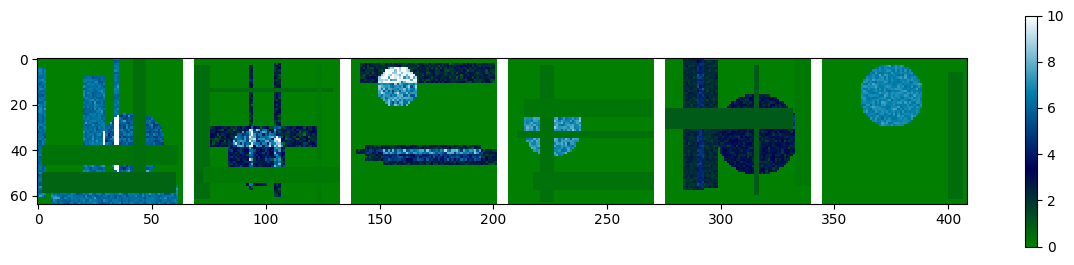

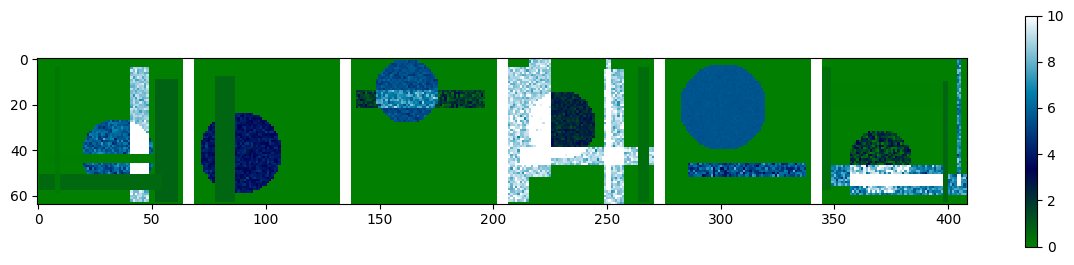

tensor([1, 1, 0, 0, 1, 0])


In [29]:
# Visualisation

img1, img2, labels, _, _ = next(iter(dataloaders['viz']))

fig0 = plt.figure(0, figsize=(15, 3))
voir_batch2D(img1, nx = 8, fig = fig0, k=0, min_scale=0,max_scale=10)
fig1 = plt.figure(1, figsize=(15, 3))
voir_batch2D(img2, nx = 8, fig = fig1, k=0, min_scale=0,max_scale=10)

print(labels)


**Q0** How is done the separation between training and validation done here?

**Q1** What is the role of *super_flip*? And that of the *oracle* function?

Augmentation de données.
Intensité to label.

**Q2** Are all pairs of images equally easy to order?

Non


**Exercise #2:** Siamese Learning

During training, batches of image pairs are compared. Basic siamese network training involves passing each image in the pair independently through the model and penalizing the model when the outputs are arranged in the wrong order.

The simplest way to do this is to consider the positive part of the difference between the outputs. This is what the following cost function does:

In [31]:
# Hinge Loss function

def label_to_sgn(label):  # 0 -> 1  and 1 -> -1
    sgn = torch.where(label == 0, 1, -1)
    return sgn

class HingeLoss(torch.nn.Module):
    def __init__(self, margin=0.1):
        super(HingeLoss, self).__init__()
        self.margin = margin

    def forward(self, output0, output1, label):
        sgn = label_to_sgn(label)
        diff = sgn * (output1 - output0)

        loss = torch.relu(diff + self.margin).mean()
        return loss

**Q1** Write the training loop and run it for 20 epochs. Keep track of the successive accuracies.

In [32]:
num_epochs = 20
channels = 1

# With a ResNet18
from torchvision.models import resnet18
model = resnet18(num_classes=1)
model.conv1 =  nn.Conv2d(channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
# Init the new conv layer
nn.init.kaiming_normal_(model.conv1.weight, mode="fan_out", nonlinearity="relu")


device = torch.device("cuda:0")
model = model.to(device)

criterion = HingeLoss(0.1)
optimizer = optim.Adam(model.parameters(), lr = 0.002 )

# Loss function and optimizer
criterion = HingeLoss(margin=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [36]:
from tqdm import tqdm, notebook

train_accs = []
val_accs = []

phases = ['train', 'val']

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in phases:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0
        data_loader = notebook.tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Epoch {epoch}', leave= phase == 'train')
        # Iterate over data.
        for img1, img2, labels, _, _ in data_loader:

            img1 = img1.to(device)
            img2 = img2.to(device)
            labels = labels.to(device).detach()

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
              output1 = model(img1)
              output2 = model(img2)
              _, preds = torch.max(torch.cat((output1, output2), dim=1), 1)

              loss = criterion(output1, output2, labels.to(torch.float32).unsqueeze(dim=1))

              if(phase == 'train'):
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * img1.size(0)
            running_corrects += torch.sum(preds == labels.data).double().item()

            data_loader.set_postfix(loss=f'{loss.item():.4f}', refresh=False)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'train':
            train_accs.append(epoch_acc)

        if phase == 'val':
            val_accs.append(epoch_acc)


Epoch 1/20
----------


Train Epoch 0:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.1301 Acc: 0.7033


Val Epoch 0:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0508 Acc: 0.7910
Epoch 2/20
----------


Train Epoch 1:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0488 Acc: 0.7966


Val Epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0437 Acc: 0.8145
Epoch 3/20
----------


Train Epoch 2:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0421 Acc: 0.8274


Val Epoch 2:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0390 Acc: 0.8465
Epoch 4/20
----------


Train Epoch 3:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0383 Acc: 0.8407


Val Epoch 3:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0385 Acc: 0.8430
Epoch 5/20
----------


Train Epoch 4:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0366 Acc: 0.8549


Val Epoch 4:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0354 Acc: 0.8510
Epoch 6/20
----------


Train Epoch 5:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0345 Acc: 0.8588


Val Epoch 5:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0313 Acc: 0.8770
Epoch 7/20
----------


Train Epoch 6:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0331 Acc: 0.8650


Val Epoch 6:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0301 Acc: 0.8810
Epoch 8/20
----------


Train Epoch 7:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0312 Acc: 0.8725


Val Epoch 7:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0336 Acc: 0.8700
Epoch 9/20
----------


Train Epoch 8:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0328 Acc: 0.8695


Val Epoch 8:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0291 Acc: 0.8870
Epoch 10/20
----------


Train Epoch 9:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0313 Acc: 0.8752


Val Epoch 9:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0297 Acc: 0.8860
Epoch 11/20
----------


Train Epoch 10:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0293 Acc: 0.8816


Val Epoch 10:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0288 Acc: 0.8870
Epoch 12/20
----------


Train Epoch 11:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0294 Acc: 0.8832


Val Epoch 11:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0300 Acc: 0.8810
Epoch 13/20
----------


Train Epoch 12:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0295 Acc: 0.8811


Val Epoch 12:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0260 Acc: 0.8955
Epoch 14/20
----------


Train Epoch 13:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0280 Acc: 0.8888


Val Epoch 13:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0268 Acc: 0.8945
Epoch 15/20
----------


Train Epoch 14:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0272 Acc: 0.8920


Val Epoch 14:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0302 Acc: 0.8775
Epoch 16/20
----------


Train Epoch 15:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0267 Acc: 0.8945


Val Epoch 15:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0291 Acc: 0.8905
Epoch 17/20
----------


Train Epoch 16:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0268 Acc: 0.8931


Val Epoch 16:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0321 Acc: 0.8675
Epoch 18/20
----------


Train Epoch 17:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0272 Acc: 0.8896


Val Epoch 17:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0281 Acc: 0.8805
Epoch 19/20
----------


Train Epoch 18:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0266 Acc: 0.8965


Val Epoch 18:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0288 Acc: 0.8890
Epoch 20/20
----------


Train Epoch 19:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0256 Acc: 0.8954


Val Epoch 19:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0287 Acc: 0.8870


**Q3** Check the learning curve.

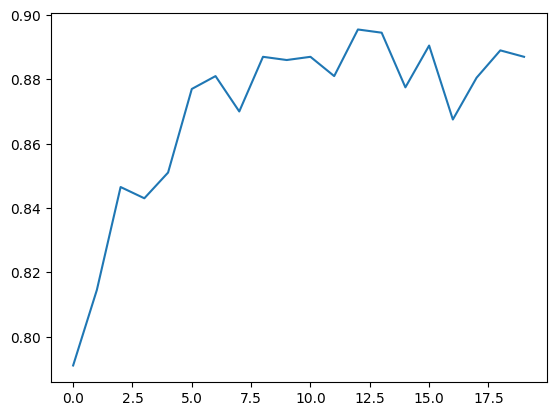

In [38]:
plt.plot(val_accs)

**Q4** Interprete the following scatterplot:

Text(0, 0.5, '$\\hat{y}$')

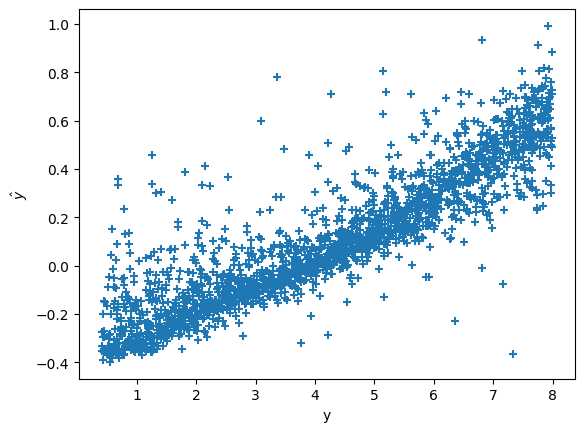

In [39]:
# true (mean) pixel intensity on the disk:
ys = []
# outputs of the network:
yhats = []

# browse the test set:
for name in names_test:
    # get true mean intensity on the disk
    y = label_dict_test[name]['y']
    ys.append(y)

    path = join(dir_images_test, name)
    image = torch.load(path)
    image = image.cuda().unsqueeze(dim=0)

    # get model output
    yhat = model.eval()(image)
    yhat = yhat.item()
    yhats.append(yhat)

# make np array
ys = np.array(ys)
yhats = np.array(yhats)

# scatterplot
plt.figure(num=10)
plt.scatter(ys, yhats, marker='+')
plt.xlabel('y')
plt.ylabel('$\hat{y}$')


**Q5** Calculate the Spearman and Kendall rank correlations. Which of the two is related to the accuracy measure?


In [40]:
import scipy

In [41]:
scipy.stats.spearmanr(ys, yhats)

SignificanceResult(statistic=0.9055553893888473, pvalue=0.0)

In [42]:
scipy.stats.kendalltau(ys, yhats)

SignificanceResult(statistic=0.7566993496748373, pvalue=0.0)

**Q6** We extend the training to 50 epochs. Load the following checkpoint, revisit questions 4 and 5 with this model, and provide comments.

In [43]:
os.chdir('/content')
! wget https://www.grosfichiers.com/WUuEwrxaf65_vySRhNAbepk
PATH_checkpoint = './WUuEwrxaf65_vySRhNAbepk'

--2023-12-22 08:40:26--  https://www.grosfichiers.com/WUuEwrxaf65_vySRhNAbepk
Resolving www.grosfichiers.com (www.grosfichiers.com)... 51.68.254.173
Connecting to www.grosfichiers.com (www.grosfichiers.com)|51.68.254.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134182874 (128M) [application/octet-stream]
Saving to: ‘WUuEwrxaf65_vySRhNAbepk’

WUuEwrxaf65_vySRhNA 100%[===================>] 127.97M  25.6MB/s    in 5.7s    

2023-12-22 08:40:32 (22.5 MB/s) - ‘WUuEwrxaf65_vySRhNAbepk’ saved [134182874/134182874]



In [112]:
model_loaded = resnet18(num_classes=1)
model_loaded.conv1 =  nn.Conv2d(channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
model_loaded = model_loaded.to(device)
model_loaded.load_state_dict(torch.load(PATH_checkpoint)['model'])

optimizer_loaded = optim.Adam(model.parameters(), lr=0.001)
optimizer_loaded.load_state_dict(torch.load(PATH_checkpoint)['optimizer'])

Text(0, 0.5, '$\\hat{y}$')

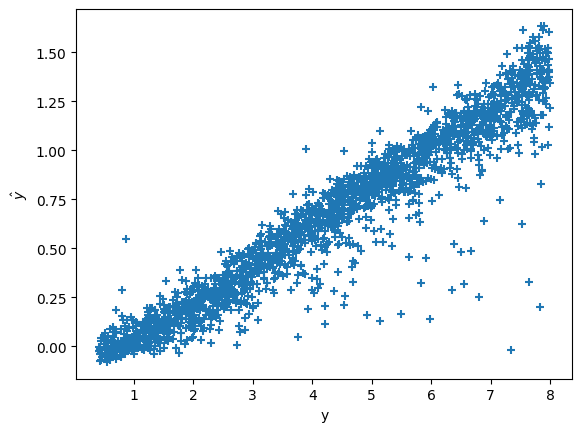

In [68]:
# true (mean) pixel intensity on the disk:
ys = []
# outputs of the network:
yhats = []

# browse the test set:
for name in names_test:
    # get true mean intensity on the disk
    y = label_dict_test[name]['y']
    ys.append(y)

    path = join(dir_images_test, name)
    image = torch.load(path)
    image = image.cuda().unsqueeze(dim=0)

    # get model output
    yhat = model_loaded.eval()(image)
    yhat = yhat.item()
    yhats.append(yhat)

# make np array
ys = np.array(ys)
yhats = np.array(yhats)

# scatterplot
plt.figure(num=10)
plt.scatter(ys, yhats, marker='+')
plt.xlabel('y')
plt.ylabel('$\hat{y}$')


In [69]:
scipy.stats.spearmanr(ys, yhats)

SignificanceResult(statistic=0.9596493854123463, pvalue=0.0)

In [70]:
scipy.stats.kendalltau(ys, yhats)

SignificanceResult(statistic=0.8454857428714356, pvalue=0.0)

**Q7** How would you improve performance?

Curriculum Learning:
- Seek more "challenging" pairs towards the end of training.

Optimization:
- Consider adding a learning rate scheduler.

Other Loss Functions:
- Explore RankNet loss.
- Explore Listnet Loss.

**Exercice #3** Curriculum Learning

One idea is to make the problem harder after an initial training phase. The following code allows you to retrieve a ResNet18 trained for 50 epochs, the optimizer, and the associated learning curve:

**Q1** Take the ResNet18 trained on 50 epochs. Continue training for an additional 20 epochs without changing the dataloader. Remember to store accuracies related to the validation set and outputs related to the test set.

In [99]:
num_epochs = 20

In [100]:
# Dataset instantiation:
dataset_train = DatasetOrderedPairs(dir_images_trainval, label_dict_trainval, transforms['train'])
dataset_val = DatasetOrderedPairs(dir_images_trainval, label_dict_trainval, transforms['val'])
dataset_test = DatasetOrderedPairs(dir_images_test, label_dict_test, transforms['test'])

datasets = {'train': dataset_train, 'val': dataset_val, 'test': dataset_test}

In [101]:
# Samplers and loaders
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)

samplers = {'train': train_sampler, 'val': val_sampler}

batch_size = 64

dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=batch_size, shuffle=False, sampler=samplers[x], num_workers=2) for x in ['train', 'val']}
dataloaders['test'] = torch.utils.data.DataLoader(datasets['test'], batch_size=batch_size, shuffle=False, num_workers=0)
dataset_sizes = {'train': len(names_train), 'val': len(names_val), 'test': len(names_test)}

dataloaders['viz'] = torch.utils.data.DataLoader(datasets['train'], batch_size=6, shuffle=False, num_workers=0)

In [102]:
from tqdm import tqdm, notebook

train_accs = []
val_accs = []

phases = ['train', 'val']

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in phases:
        if phase == 'train':
            model_loaded.train()  # Set model to training mode
        else:
            model_loaded.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0
        data_loader = notebook.tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Epoch {epoch}', leave= phase == 'train')
        # Iterate over data.
        for img1, img2, labels, _, _ in data_loader:

            img1 = img1.to(device)
            img2 = img2.to(device)
            labels = labels.to(device).detach()

            optimizer_loaded.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
              output1 = model_loaded(img1)
              output2 = model_loaded(img2)
              _, preds = torch.max(torch.cat((output1, output2), dim=1), 1)

              loss = criterion(output1, output2, labels.to(torch.float32).unsqueeze(dim=1))

              if(phase == 'train'):
                loss.backward()
                optimizer_loaded.step()

            # statistics
            running_loss += loss.item() * img1.size(0)
            running_corrects += torch.sum(preds == labels.data).double().item()

            data_loader.set_postfix(loss=f'{loss.item():.4f}', refresh=False)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'train':
            train_accs.append(epoch_acc)

        if phase == 'val':
            val_accs.append(epoch_acc)


Epoch 1/20
----------


Train Epoch 0:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0222 Acc: 0.9201


Val Epoch 0:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0188 Acc: 0.9295
Epoch 2/20
----------


Train Epoch 1:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0195 Acc: 0.9284


Val Epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0173 Acc: 0.9360
Epoch 3/20
----------


Train Epoch 2:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0209 Acc: 0.9243


Val Epoch 2:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0214 Acc: 0.9305
Epoch 4/20
----------


Train Epoch 3:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0218 Acc: 0.9203


Val Epoch 3:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0196 Acc: 0.9250
Epoch 5/20
----------


Train Epoch 4:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0213 Acc: 0.9196


Val Epoch 4:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0210 Acc: 0.9265
Epoch 6/20
----------


Train Epoch 5:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0210 Acc: 0.9245


Val Epoch 5:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0205 Acc: 0.9265
Epoch 7/20
----------


Train Epoch 6:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0227 Acc: 0.9193


Val Epoch 6:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0210 Acc: 0.9220
Epoch 8/20
----------


Train Epoch 7:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0203 Acc: 0.9220


Val Epoch 7:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0192 Acc: 0.9305
Epoch 9/20
----------


Train Epoch 8:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0205 Acc: 0.9244


Val Epoch 8:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0162 Acc: 0.9380
Epoch 10/20
----------


Train Epoch 9:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0222 Acc: 0.9180


Val Epoch 9:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0232 Acc: 0.9170
Epoch 11/20
----------


Train Epoch 10:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0217 Acc: 0.9227


Val Epoch 10:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0199 Acc: 0.9355
Epoch 12/20
----------


Train Epoch 11:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0212 Acc: 0.9213


Val Epoch 11:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0235 Acc: 0.9160
Epoch 13/20
----------


Train Epoch 12:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0213 Acc: 0.9223


Val Epoch 12:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0207 Acc: 0.9230
Epoch 14/20
----------


Train Epoch 13:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0195 Acc: 0.9284


Val Epoch 13:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0203 Acc: 0.9290
Epoch 15/20
----------


Train Epoch 14:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0214 Acc: 0.9226


Val Epoch 14:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0198 Acc: 0.9260
Epoch 16/20
----------


Train Epoch 15:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0200 Acc: 0.9220


Val Epoch 15:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0192 Acc: 0.9300
Epoch 17/20
----------


Train Epoch 16:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0227 Acc: 0.9163


Val Epoch 16:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0237 Acc: 0.9145
Epoch 18/20
----------


Train Epoch 17:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0216 Acc: 0.9214


Val Epoch 17:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0224 Acc: 0.9205
Epoch 19/20
----------


Train Epoch 18:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0214 Acc: 0.9200


Val Epoch 18:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0200 Acc: 0.9215
Epoch 20/20
----------


Train Epoch 19:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0207 Acc: 0.9231


Val Epoch 19:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0211 Acc: 0.9210


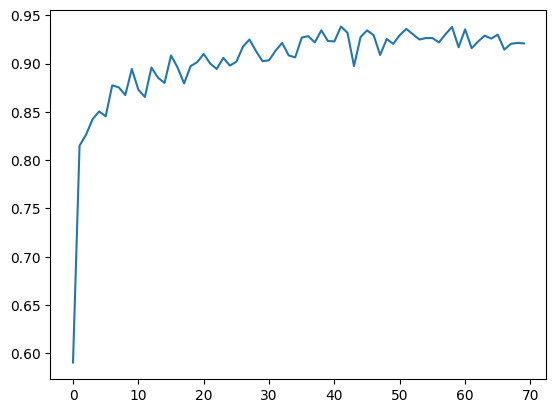

In [103]:
old_vals = torch.load(PATH_checkpoint)['val_accs']
val_accs = old_vals + val_accs
plt.plot(val_accs)
val_accs_easy = val_accs

**Q2** We will now continue training on pairs that are harder to order. For this purpose, we have the 'Dataset_finer_pairs' dataset below. Train for 20 epochs using this dataset (use epoch_ray = 1.).

In [105]:
def make_dic_ray(imgs, dic, ray):

  ys = np.array([dic[img]['y'] for img in imgs])
  imgs = np.array(imgs)
  dic_ray = {}
  for i,img in enumerate(imgs):
    y = ys[i]
    # on limite la paire à des disques proches en intensité
    dic_ray[img] = list(imgs[np.abs(ys - y) < ray])

  return dic_ray

class Dataset_finer_pairs(torch.utils.data.Dataset):
    def __init__(self, images_dir,  dic, transfo = None, ray=0.5):
        self.images_dir = images_dir
        self.transfo = transfo
        self.imgs = sorted(ls(images_dir))
        self.dic = dic
        self.dic_ray = make_dic_ray(self.imgs, dic, ray)

    def __getitem__(self,idx):

        name0 = self.imgs[idx]
        name1 = choice(self.dic_ray[name0])
        label = oracle(name0, name1, self.dic)


        #get the images
        path0 = os.path.join(self.images_dir, name0)
        img0 =  torch.load(path0)
        path1 = os.path.join(self.images_dir, name1)
        img1 = torch.load(path1)


        if self.transfo is not None:
            img0 = self.transfo(img0)
            img1 = self.transfo(img1)

        return img0, img1,  torch.from_numpy(np.array(label)).long(), name0, name1

    def __len__(self):
        return len(self.imgs)

In [113]:
num_epochs = 20

In [114]:
# Dataset instantiation:
dataset_train = Dataset_finer_pairs(dir_images_trainval, label_dict_trainval, transforms['train'], ray = 1.0)
dataset_val = DatasetOrderedPairs(dir_images_trainval, label_dict_trainval, transforms['val'])
dataset_test = Dataset_finer_pairs(dir_images_test, label_dict_test, transforms['test'])

datasets = {'train': dataset_train, 'val': dataset_val, 'test': dataset_test}

In [115]:
# Samplers and loaders
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)

samplers = {'train': train_sampler, 'val': val_sampler}

batch_size = 64

dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=batch_size, shuffle=False, sampler=samplers[x], num_workers=2) for x in ['train', 'val']}
dataloaders['test'] = torch.utils.data.DataLoader(datasets['test'], batch_size=batch_size, shuffle=False, num_workers=0)
dataset_sizes = {'train': len(names_train), 'val': len(names_val), 'test': len(names_test)}

dataloaders['viz'] = torch.utils.data.DataLoader(datasets['train'], batch_size=6, shuffle=False, num_workers=0)

In [116]:
from tqdm import tqdm, notebook

train_accs = []
val_accs = []

phases = ['train', 'val']

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in phases:
        if phase == 'train':
            model_loaded.train()  # Set model to training mode
        else:
            model_loaded.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0
        data_loader = notebook.tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Epoch {epoch}', leave= phase == 'train')
        # Iterate over data.
        for img1, img2, labels, _, _ in data_loader:

            img1 = img1.to(device)
            img2 = img2.to(device)
            labels = labels.to(device).detach()

            optimizer_loaded.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
              output1 = model_loaded(img1)
              output2 = model_loaded(img2)
              _, preds = torch.max(torch.cat((output1, output2), dim=1), 1)

              loss = criterion(output1, output2, labels.to(torch.float32).unsqueeze(dim=1))

              if(phase == 'train'):
                loss.backward()
                optimizer_loaded.step()

            # statistics
            running_loss += loss.item() * img1.size(0)
            running_corrects += torch.sum(preds == labels.data).double().item()

            data_loader.set_postfix(loss=f'{loss.item():.4f}', refresh=False)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'train':
            train_accs.append(epoch_acc)

        if phase == 'val':
            val_accs.append(epoch_acc)


Epoch 1/20
----------


Train Epoch 0:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0681 Acc: 0.7381


Val Epoch 0:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0211 Acc: 0.9255
Epoch 2/20
----------


Train Epoch 1:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0683 Acc: 0.7404


Val Epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0216 Acc: 0.9220
Epoch 3/20
----------


Train Epoch 2:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0671 Acc: 0.7459


Val Epoch 2:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0186 Acc: 0.9275
Epoch 4/20
----------


Train Epoch 3:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0683 Acc: 0.7388


Val Epoch 3:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0204 Acc: 0.9220
Epoch 5/20
----------


Train Epoch 4:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0671 Acc: 0.7389


Val Epoch 4:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0197 Acc: 0.9255
Epoch 6/20
----------


Train Epoch 5:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0683 Acc: 0.7438


Val Epoch 5:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0206 Acc: 0.9205
Epoch 7/20
----------


Train Epoch 6:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0678 Acc: 0.7371


Val Epoch 6:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0210 Acc: 0.9230
Epoch 8/20
----------


Train Epoch 7:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0684 Acc: 0.7355


Val Epoch 7:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0217 Acc: 0.9230
Epoch 9/20
----------


Train Epoch 8:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0671 Acc: 0.7424


Val Epoch 8:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0207 Acc: 0.9240
Epoch 10/20
----------


Train Epoch 9:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0676 Acc: 0.7450


Val Epoch 9:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0190 Acc: 0.9335
Epoch 11/20
----------


Train Epoch 10:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0675 Acc: 0.7412


Val Epoch 10:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0212 Acc: 0.9235
Epoch 12/20
----------


Train Epoch 11:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0704 Acc: 0.7370


Val Epoch 11:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0185 Acc: 0.9370
Epoch 13/20
----------


Train Epoch 12:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0683 Acc: 0.7356


Val Epoch 12:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0207 Acc: 0.9280
Epoch 14/20
----------


Train Epoch 13:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0680 Acc: 0.7405


Val Epoch 13:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0179 Acc: 0.9290
Epoch 15/20
----------


Train Epoch 14:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0701 Acc: 0.7302


Val Epoch 14:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0221 Acc: 0.9115
Epoch 16/20
----------


Train Epoch 15:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0683 Acc: 0.7408


Val Epoch 15:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0186 Acc: 0.9285
Epoch 17/20
----------


Train Epoch 16:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0699 Acc: 0.7320


Val Epoch 16:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0228 Acc: 0.9225
Epoch 18/20
----------


Train Epoch 17:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0678 Acc: 0.7370


Val Epoch 17:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0198 Acc: 0.9225
Epoch 19/20
----------


Train Epoch 18:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0699 Acc: 0.7302


Val Epoch 18:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0228 Acc: 0.9180
Epoch 20/20
----------


Train Epoch 19:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0668 Acc: 0.7448


Val Epoch 19:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0186 Acc: 0.9275


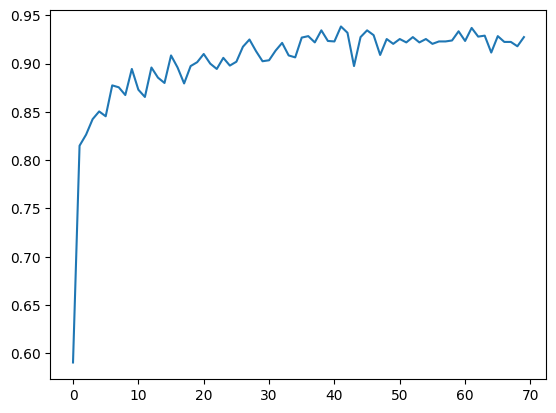

In [117]:
old_vals = torch.load(PATH_checkpoint)['val_accs']
val_accs = old_vals + val_accs
plt.plot(val_accs)
val_accs_harder = val_accs

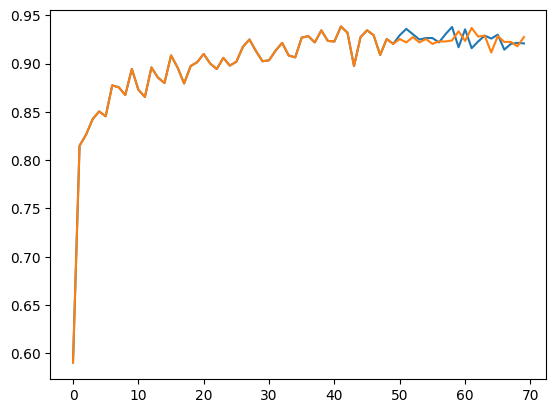

In [118]:
plt.plot(val_accs_easy)
plt.plot(val_accs_harder)


**Q3** Why is the training accuracy lower than before? Compare the learning curves (validation accuracies) and the results on the test set. Discuss.

**Exercise #4** RankNet Loss (and ListNet Loss)

A milder version of the Hinge Loss has been widely used, particularly in search engine learning, known as the RankNet Loss.

This cost function is derived from a parametric probabilistic model, the [Bradley-Terry model](https://en.wikipedia.org/wiki/Bradley%E2%80%93Terry_model).

In a general version, it is assumed that the outcome of a comparison (or match) between two objects "0" and "1" (or two teams) is random and depends on real values associated with the objects (the "team levels") as follows:
\begin{align}
P_0 = \dfrac{f(y_0)}{f(y_0) + f(y_1)}
\tag{1}
\end{align}
Where $P_0$ is the probability of choosing object "0" (or the first team winning), and $f$ is a strictly increasing function with positive values.

**Q1** In the case where $f(y) = e^{\sigma y}$, what do the choice probabilities depend on? Write the log-likelihood of the event "object $x$ is chosen."

**Q2** Derive an appropriate cost function for our ranking problem based on the given log-likelihood.

**Q3** Implement and compare over twenty epochs.